In [1]:
#Importing Drive
import sys
runningOnColab = 'google.colab' in sys.modules
if runningOnColab:
  from google.colab import drive
  drive.mount('/content/drive')
  %cd '/content/drive/Shareddrives/ECE232E/Project 3'


Mounted at /content/drive
/content/drive/Shareddrives/ECE232E/Project 3


In [2]:
!pip install cvxopt
!pip install tqdm

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from cvxopt import solvers, matrix
from tqdm import tqdm

#Question 1

In [4]:
rwd_1 = np.array([[0,0,0,0,0,0,0,0,0,0], 
         [0,0,0,0,0,0,0,0,0,0], 
         [0,0,0,0,0,-10,-10,0,0,0], 
         [0,0,0,0,0,-10,-10,0,0,0],
         [0,-10,-10,0,0,0,0,0,0,0],
         [0,-10,-10,0,0,0,0,0,0,0],
         [0,0,0,0,0,0,0,0,0,0],
         [0,0,0,0,0,0,0,0,0,0],
         [0,0,-10,-10,0,0,0,0,0,0],
         [0,0,-10,-10,0,0,0,0,0,1]])

rwd_2 = np.array([[0,0,0,0,0,0,0,0,0,0], 
         [0,0,0,0,-100,-100,-100,0,0,0], 
         [0,0,0,0,-100,0,-100,0,0,0], 
         [0,0,0,0,-100,0,-100,-100,-100,0],
         [0,0,0,0,-100,0,0,0,-100,0],
         [0,0,0,0,-100,0,0,0,-100,0],
         [0,0,0,0,-100,0,0,0,-100,0],
         [0,0,0,0,0,0,-100,-100,-100,0],
         [0,0,0,0,0,0,-100,0,0,0],
         [0,0,0,0,0,0,0,0,0,10]])

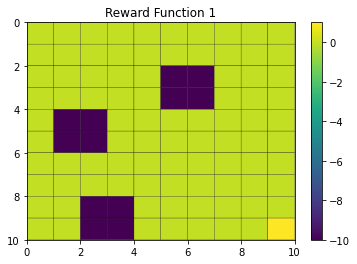

In [7]:
plt.pcolor(rwd_1, edgecolors = 'black')
plt.gca().invert_yaxis()
plt.colorbar()
plt.title("Reward Function 1")
plt.savefig('Q1a.png', dpi = 300, bbox_inches = 'tight')
plt.show()

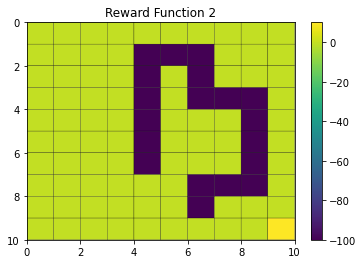

In [8]:
plt.pcolor(rwd_2, edgecolors = 'black')
plt.gca().invert_yaxis()
plt.colorbar()
plt.title("Reward Function 2")
plt.savefig('Q1b.png', dpi = 300, bbox_inches = 'tight')
plt.show()

#Question 2

In [9]:
state_num = np.zeros((10,10))
k=0
for i in range(0,10):
    for j in range(0,10):
        state_num[j][i]=k
        k+=1

In [10]:
def tp_calc(w):
    tp_u= np.zeros((100,100)) #Up
    tp_d= np.zeros((100,100)) #Down
    tp_l= np.zeros((100,100)) #Left
    tp_r= np.zeros((100,100)) #Right
    
    #Up
    for i in range(0,100):
        if(i%10==0):
            tp_u[i][i]+=w/4
        else:
            tp_u[i][i-1]=1-w+w/4
        if(i-10<0):
            tp_u[i][i]+=w/4
        else:
            tp_u[i][i-10]=w/4
        if(i+10>99):
            tp_u[i][i]+=w/4
        else:
            tp_u[i][i+10]=w/4
        if((i+1)%10==0):
            tp_u[i][i]+=w/4
        else:
            tp_u[i][i+1]=w/4
        if(i%10==0):                     
            tp_u[i][i]+=1-w   
        
    #Down
    for i in range(0,100):
        if(i%10==0):
            tp_d[i][i]+=w/4
        else:
            tp_d[i][i-1]=w/4
        if(i-10<0):
            tp_d[i][i]+=w/4
        else:
            tp_d[i][i-10]=w/4
        if(i+10>99):
            tp_d[i][i]+=w/4
        else:
            tp_d[i][i+10]=w/4
        if((i+1)%10==0):
            tp_d[i][i]+=w/4
        else:
            tp_d[i][i+1]=1-w+w/4
        if((i+1)%10==0):                      
            tp_d[i][i]+=1-w
    
    #Left
    for i in range(0,100):
        if(i%10==0):
            tp_l[i][i]+=w/4
        else:
            tp_l[i][i-1]=w/4
        if(i-10<0):
            tp_l[i][i]+=w/4
        else:
            tp_l[i][i-10]=1-w+w/4
        if(i+10>99):
            tp_l[i][i]+=w/4
        else:
            tp_l[i][i+10]=w/4
        if((i+1)%10==0):
            tp_l[i][i]+=w/4
        else:
            tp_l[i][i+1]=w/4
        if(i-10<0):                      
            tp_l[i][i]+=1-w
    
    #Right
    for i in range(0,100):
        if(i%10==0):
            tp_r[i][i]+=w/4
        else:
            tp_r[i][i-1]=w/4
        if(i-10<0):
            tp_r[i][i]+=w/4
        else:
            tp_r[i][i-10]=w/4
        if(i+10>99):
            tp_r[i][i]+=w/4
        else:
            tp_r[i][i+10]=1-w+w/4
        if((i+1)%10==0):
            tp_r[i][i]+=w/4
        else:
            tp_r[i][i+1]=w/4
        if(i+10>99):                      
            tp_r[i][i]+=1-w

    return tp_u, tp_d, tp_l, tp_r

In [11]:
def value_iteration(state_num,w,gamma,rwd,epsilon,tp_u, tp_d, tp_l, tp_r):
    state_val=np.zeros(100)
    delta=np.inf
    r = (rwd.T).ravel()
    N = 0
    while(delta>epsilon):
        delta=0
        old_state_val=np.copy(state_val)
        for s in range(0,100):
            u_val=np.sum(tp_u[s]*(r+gamma*old_state_val))
            d_val=np.sum(tp_d[s]*(r+gamma*old_state_val))
            l_val=np.sum(tp_l[s]*(r+gamma*old_state_val))
            r_val=np.sum(tp_r[s]*(r+gamma*old_state_val))
            state_val[s]=max(u_val,d_val,r_val,l_val)
            delta=max(delta,abs(old_state_val[s]-state_val[s]))
        N = N+1
    state_val = np.transpose(state_val.reshape(10,10))
    return state_val, N

In [12]:
w = 0.1
gamma = 0.8
epsilon = 0.01
tp_u, tp_d, tp_l, tp_r = tp_calc(w)
V_opt, N=value_iteration(state_num,w,gamma,rwd_1,epsilon,tp_r,tp_l,tp_u,tp_d)
print("Number of steps needed to converge:", N)

Number of steps needed to converge: 22


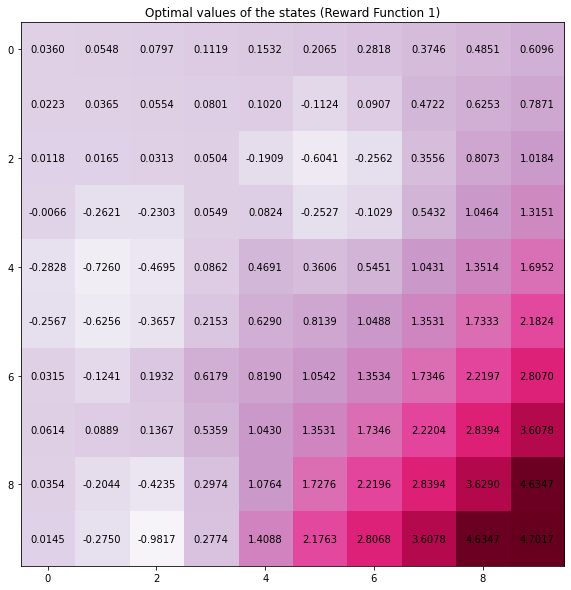

In [13]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(V_opt, cmap="PuRd")
for i in range(10):
    for j in range(10):
        c = "{:.4f}".format(V_opt[j,i])
        ax.text(i, j, str(c), va='center', ha='center')
plt.title("Optimal values of the states (Reward Function 1)")
plt.savefig('Q2a.png', dpi=300, bbox_inches='tight')
plt.show()

In [14]:
def value_iteration_with_snapshots(state_num,w,gamma,rwd,epsilon,tp_u, tp_d, tp_l, tp_r,div):
    state_val=np.zeros(100)
    snapshot = []
    delta=np.inf
    r = (rwd.T).ravel()
    N = 0
    while(delta>epsilon):
        if((N==0) or (N==5) or (N==10) or (N==15) or (N==20)):
            cur_state_val = np.copy(state_val)
            cur_state_val = np.transpose(cur_state_val.reshape(10,10))
            snapshot.append(cur_state_val) 
        delta=0
        old_state_val=np.copy(state_val)
        for s in range(0,100):
            u_val=np.sum(tp_u[s]*(r+gamma*old_state_val))
            d_val=np.sum(tp_d[s]*(r+gamma*old_state_val))
            l_val=np.sum(tp_l[s]*(r+gamma*old_state_val))
            r_val=np.sum(tp_r[s]*(r+gamma*old_state_val))
            state_val[s]=max(u_val,d_val,r_val,l_val)
            delta=max(delta,abs(old_state_val[s]-state_val[s]))
        N = N+1
    return snapshot

In [15]:
snapshots = value_iteration_with_snapshots(state_num,w,gamma,rwd_1,epsilon,tp_r,tp_l,tp_u,tp_d,4)

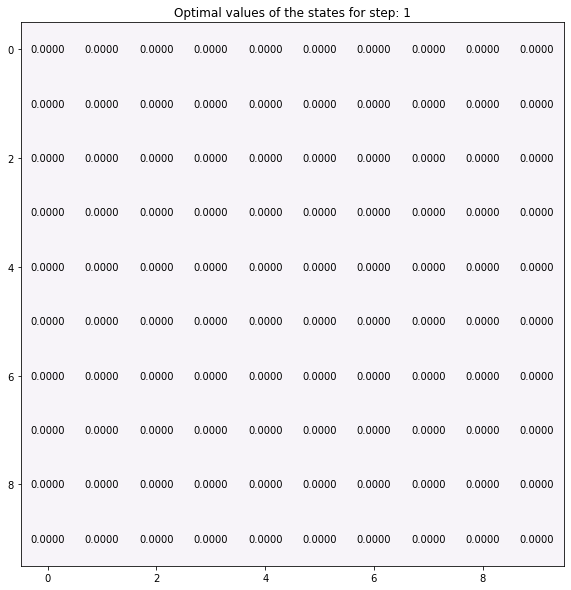

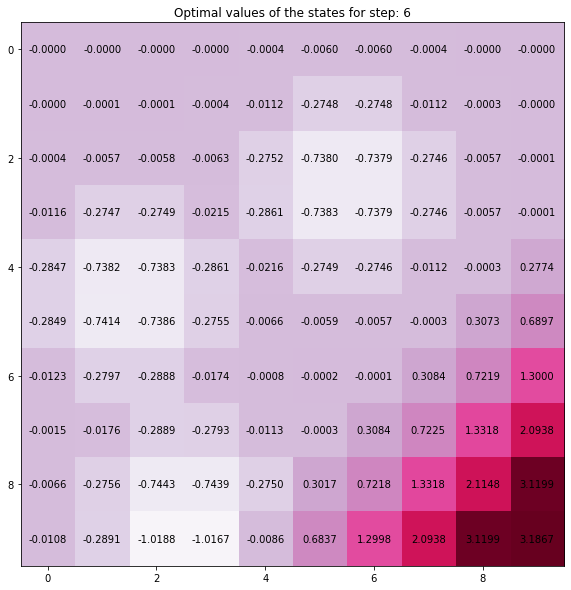

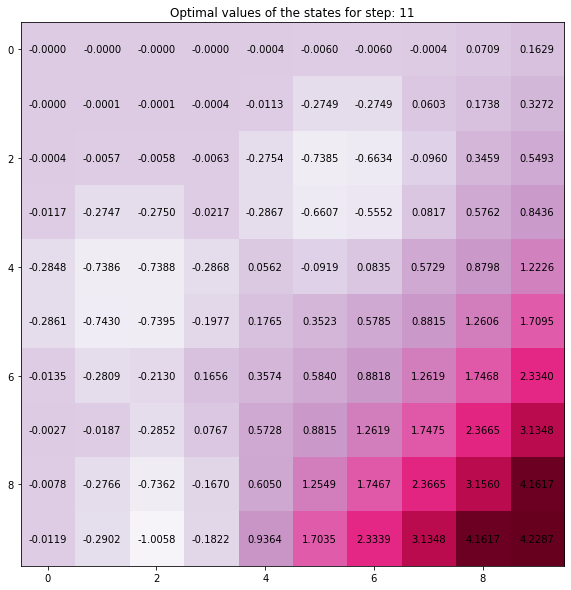

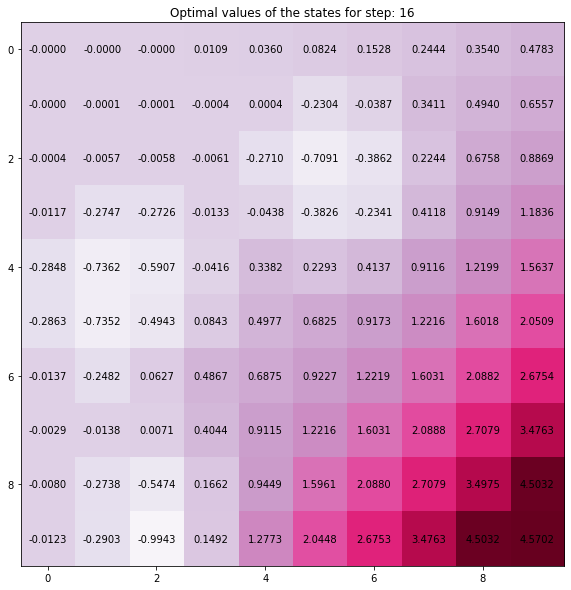

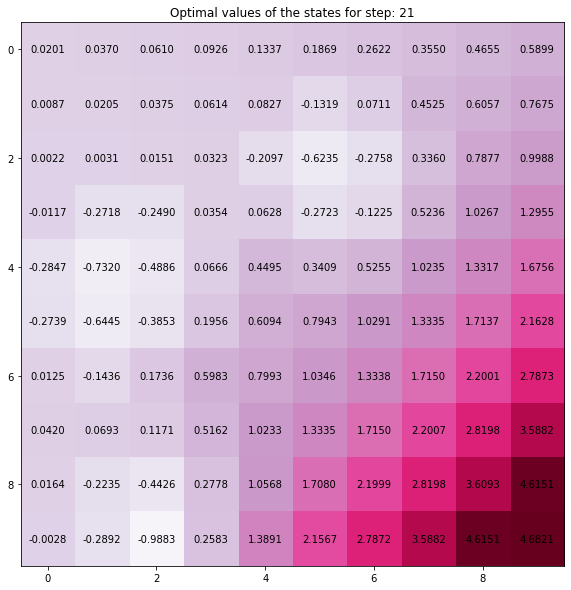

In [16]:
N = 1
for k in range(len(snapshots)):
    V = snapshots[k]
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.imshow(V, cmap="PuRd")
    for i in range(10):
        for j in range(10):
            c = "{:.4f}".format(V[j,i])
            ax.text(i, j, str(c), va='center', ha='center')
    plt.title("Optimal values of the states for step: "+str(N))
    plt.savefig('Q2b'+str(N)+'.png',dpi=300,bbox_inches='tight')
    N = N+5
    plt.show()

#Question 3

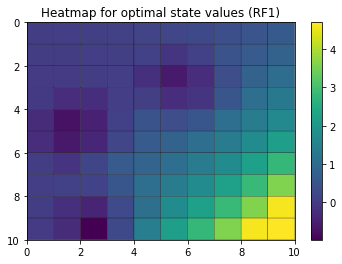

In [17]:
plt.pcolor(V_opt,edgecolors='black')
plt.gca().invert_yaxis()
plt.colorbar()
plt.title("Heatmap for optimal state values (RF1)")
plt.savefig('Q3a.png',dpi=300,bbox_inches='tight')
plt.show()

#Question 5

In [18]:
def policy_iteration(state_num,w,gamma,rwd,epsilon,tp_u, tp_d, tp_l, tp_r):
    state_val=np.zeros(100)
    delta=np.inf
    policy=np.zeros(100)
    arrows=np.zeros(100) 
    r = (rwd.T).ravel()
    while(delta>epsilon):
        delta=0
        old_state_val=np.copy(state_val)
        for s in range(0,100):
            u_val=np.sum(tp_u[s]*(r+gamma*old_state_val))
            d_val=np.sum(tp_d[s]*(r+gamma*old_state_val))
            l_val=np.sum(tp_l[s]*(r+gamma*old_state_val))
            r_val=np.sum(tp_r[s]*(r+gamma*old_state_val))
            state_val[s]=max(u_val,d_val,r_val,l_val)
            delta=max(delta,abs(old_state_val[s]-state_val[s]))
    for s in range(0,100):
        u_val=np.sum(tp_u[s]*(r+gamma*state_val))
        d_val=np.sum(tp_d[s]*(r+gamma*state_val))
        l_val=np.sum(tp_l[s]*(r+gamma*state_val))
        r_val=np.sum(tp_r[s]*(r+gamma*state_val))
        arr=[u_val,d_val,l_val,r_val] #Up: 0, Down: 1, Left: 2, Right: 3
        policy[s]=np.amax(arr)
        arrows[s]=arr.index(np.amax(arr))
    arrows = np.transpose(arrows.reshape(10,10))
    policy = np.transpose(policy.reshape(10,10))
    pic_arrow=np.chararray((10,10),unicode=True)
    for i in range(10):
        for j in range(10):
            if(arrows[j][i]==0.):
                pic_arrow[j][i] = u'\u2191'
            elif(arrows[j][i]==1.):
                pic_arrow[j][i] = u'\u2193'
            elif(arrows[j][i]==2.):
                pic_arrow[j][i]=u'\u2190'
            elif(arrows[j][i]==3.):
                pic_arrow[j][i] = u'\u2192'
    return policy, pic_arrow, arrows

In [19]:
policy, pic_arrow, arrows = policy_iteration(state_num,w,gamma,rwd_1,epsilon,tp_u, tp_d, tp_l, tp_r)

In [20]:
print(pic_arrow)

[['→' '→' '→' '→' '→' '→' '→' '→' '↓' '↓']
 ['→' '→' '→' '↑' '↑' '↑' '→' '→' '↓' '↓']
 ['↑' '↑' '↑' '↑' '↑' '↑' '→' '→' '↓' '↓']
 ['↑' '↑' '→' '↓' '↓' '↓' '↓' '→' '↓' '↓']
 ['↑' '↑' '→' '→' '↓' '↓' '↓' '↓' '↓' '↓']
 ['↓' '↓' '→' '→' '↓' '↓' '↓' '↓' '↓' '↓']
 ['↓' '→' '→' '→' '→' '→' '→' '↓' '↓' '↓']
 ['→' '→' '→' '→' '→' '→' '→' '→' '↓' '↓']
 ['↑' '↑' '↑' '→' '→' '→' '→' '→' '→' '↓']
 ['↑' '←' '←' '→' '→' '→' '→' '→' '→' '↓']]


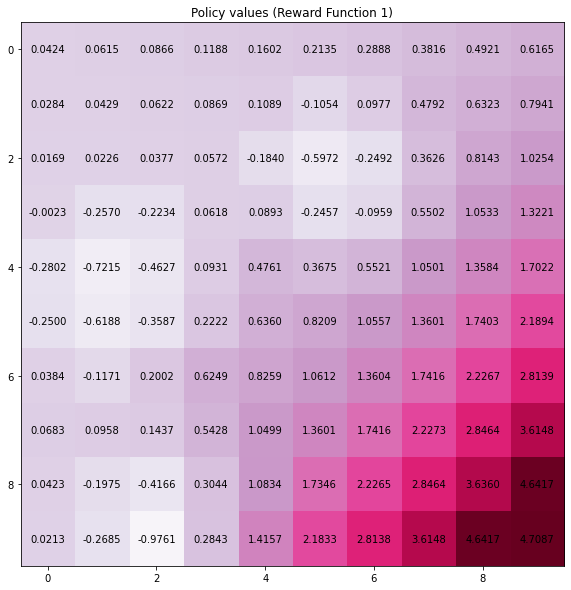

In [21]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(policy, cmap="PuRd")
for i in range(10):
    for j in range(10):
        c = "{:.4f}".format(policy[j,i])
        ax.text(i, j, str(c), va='center', ha='center')
plt.title("Policy values (Reward Function 1)")
plt.savefig('Q5.png',dpi=300,bbox_inches='tight')
plt.show()

#Question 6

In [22]:
V_opt, N=value_iteration(state_num,w,gamma,rwd_2,epsilon,tp_r,tp_l,tp_u,tp_d)
print("Number of steps needed to converge:", N)

Number of steps needed to converge: 32


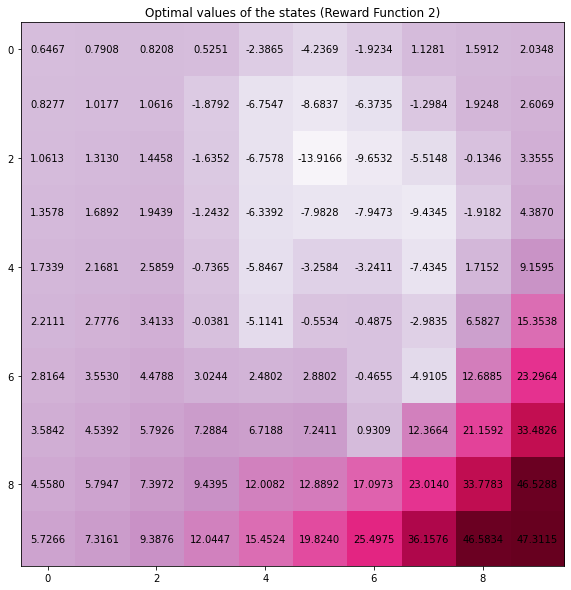

In [23]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(V_opt, cmap="PuRd")
for i in range(10):
    for j in range(10):
        c = "{:.4f}".format(V_opt[j,i])
        ax.text(i, j, str(c), va='center', ha='center')
plt.title("Optimal values of the states (Reward Function 2)")
plt.savefig('Q6.png',dpi=300,bbox_inches='tight')
plt.show()

#Question 7

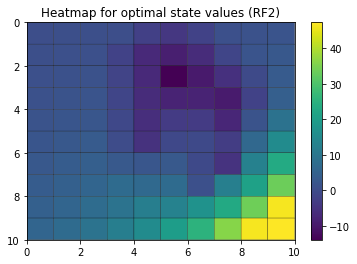

In [24]:
plt.pcolor(V_opt,edgecolors='black')
plt.gca().invert_yaxis()
plt.colorbar()
plt.title("Heatmap for optimal state values (RF2)")
plt.savefig('Q7.png',dpi=300,bbox_inches='tight')
plt.show()

#Question 8

In [25]:
policy, pic_arrow, arrows = policy_iteration(state_num,w,gamma,rwd_2,epsilon,tp_u, tp_d, tp_l, tp_r)

In [26]:
print(pic_arrow)

[['↓' '↓' '↓' '←' '←' '→' '→' '→' '→' '↓']
 ['↓' '↓' '↓' '←' '←' '↑' '→' '→' '→' '↓']
 ['↓' '↓' '↓' '←' '←' '↓' '→' '→' '→' '↓']
 ['↓' '↓' '↓' '←' '←' '↓' '↓' '↑' '→' '↓']
 ['↓' '↓' '↓' '←' '←' '↓' '↓' '↓' '→' '↓']
 ['↓' '↓' '↓' '←' '←' '↓' '↓' '←' '→' '↓']
 ['↓' '↓' '↓' '↓' '↓' '↓' '←' '←' '→' '↓']
 ['↓' '↓' '↓' '↓' '↓' '↓' '←' '↓' '↓' '↓']
 ['→' '→' '→' '↓' '↓' '↓' '↓' '↓' '↓' '↓']
 ['→' '→' '→' '→' '→' '→' '→' '→' '→' '↓']]


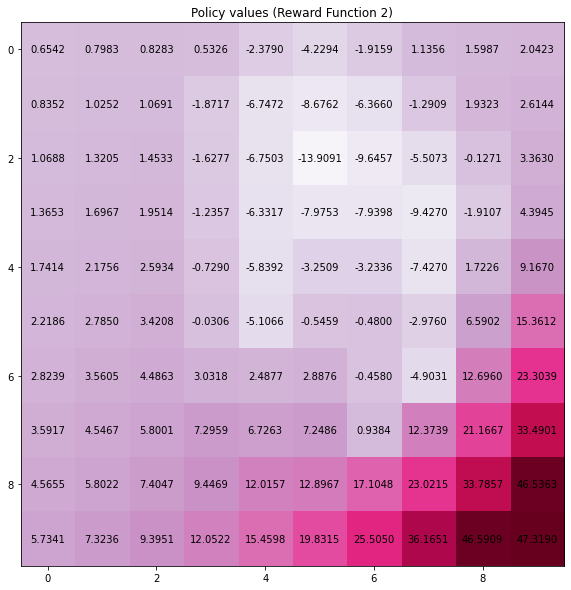

In [27]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(policy,cmap="PuRd")
for i in range(10):
    for j in range(10):
        c = "{:.4f}".format(policy[j,i])
        ax.text(i, j, str(c), va='center', ha='center')
plt.title("Policy values (Reward Function 2)")
plt.savefig('Q8.png',dpi=300,bbox_inches='tight')
plt.show()

#Question 9

Number of steps needed to converge: 19


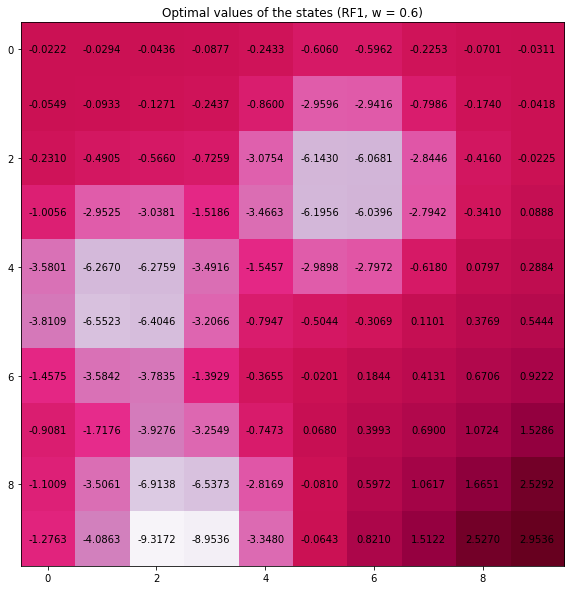

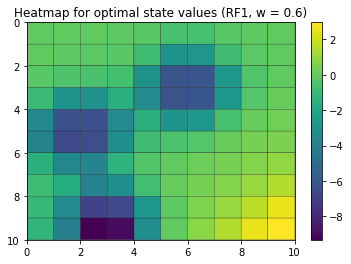

[['↑' '←' '←' '←' '←' '←' '→' '→' '→' '↑']
 ['↑' '↑' '↑' '↑' '↑' '↑' '↑' '→' '→' '↓']
 ['↑' '↑' '↑' '↑' '←' '↑' '→' '→' '→' '↓']
 ['↑' '↑' '↑' '↑' '←' '↓' '→' '→' '→' '↓']
 ['↑' '↑' '↑' '↑' '↓' '↓' '↓' '↓' '↓' '↓']
 ['↓' '↓' '→' '→' '↓' '↓' '↓' '↓' '↓' '↓']
 ['↓' '←' '→' '→' '→' '→' '→' '↓' '↓' '↓']
 ['←' '←' '←' '→' '→' '→' '→' '→' '↓' '↓']
 ['↑' '←' '←' '→' '→' '→' '→' '→' '→' '↓']
 ['↑' '←' '←' '→' '→' '→' '→' '→' '→' '↓']]


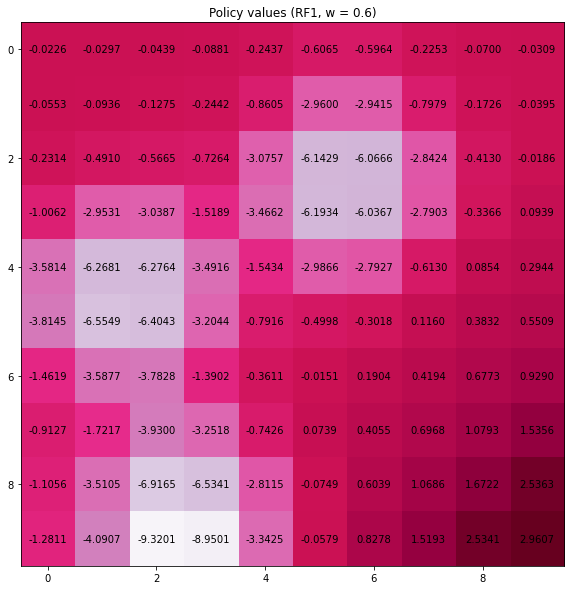

In [28]:
w = 0.6
gamma = 0.8
epsilon = 0.01
tp_u, tp_d, tp_l, tp_r = tp_calc(w)
V_opt, N=value_iteration(state_num,w,gamma,rwd_1,epsilon,tp_r,tp_l,tp_u,tp_d)
print("Number of steps needed to converge:", N)

fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(V_opt,cmap="PuRd")
for i in range(10):
    for j in range(10):
        c = "{:.4f}".format(V_opt[j,i])
        ax.text(i, j, str(c), va='center', ha='center')
plt.title("Optimal values of the states (RF1, w = 0.6)")
plt.savefig('Q9a.png',dpi=300,bbox_inches='tight')
plt.show()

plt.pcolor(V_opt,edgecolors='black')
plt.gca().invert_yaxis()
plt.colorbar()
plt.title("Heatmap for optimal state values (RF1, w = 0.6)")
plt.savefig('Q9b.png',dpi=300,bbox_inches='tight')
plt.show()

policy, pic_arrow,arrows = policy_iteration(state_num,w,gamma,rwd_1,epsilon,tp_u, tp_d, tp_l, tp_r)
print(pic_arrow)

fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(policy,cmap="PuRd")
for i in range(10):
    for j in range(10):
        c = "{:.4f}".format(policy[j,i])
        ax.text(i, j, str(c), va='center', ha='center')
plt.title("Policy values (RF1, w = 0.6)")
plt.savefig('Q9c.png',dpi=300,bbox_inches='tight')
plt.show()

Number of steps needed to converge: 27


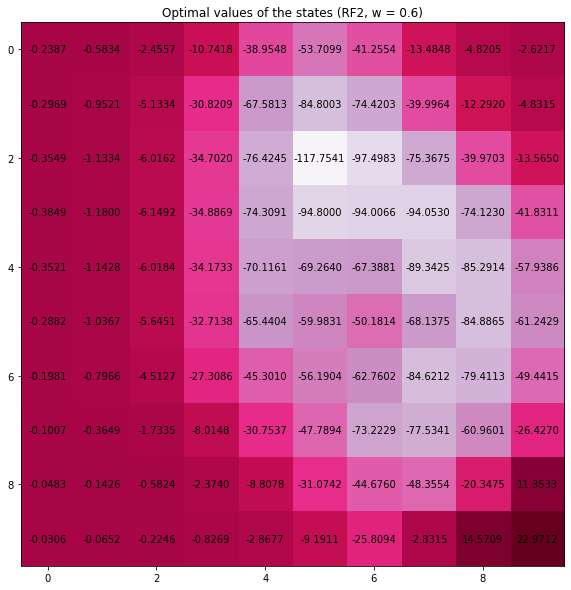

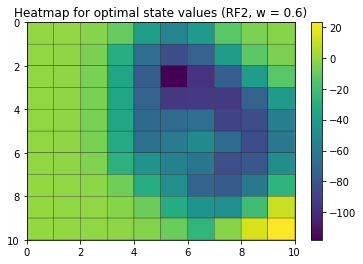

[['↑' '←' '←' '←' '←' '←' '→' '→' '→' '↑']
 ['↑' '←' '←' '←' '←' '↑' '→' '→' '↑' '↑']
 ['↑' '←' '←' '←' '←' '↓' '→' '→' '↑' '↑']
 ['↓' '←' '←' '←' '←' '↓' '↓' '↑' '↑' '↑']
 ['↓' '←' '←' '←' '←' '↓' '↓' '←' '→' '↑']
 ['↓' '←' '←' '←' '←' '→' '←' '←' '→' '↓']
 ['↓' '←' '←' '←' '←' '↓' '↑' '←' '→' '↓']
 ['↓' '←' '←' '←' '←' '←' '←' '↓' '↓' '↓']
 ['↓' '←' '←' '←' '←' '←' '↓' '↓' '↓' '↓']
 ['↓' '←' '←' '←' '←' '←' '→' '→' '→' '↓']]


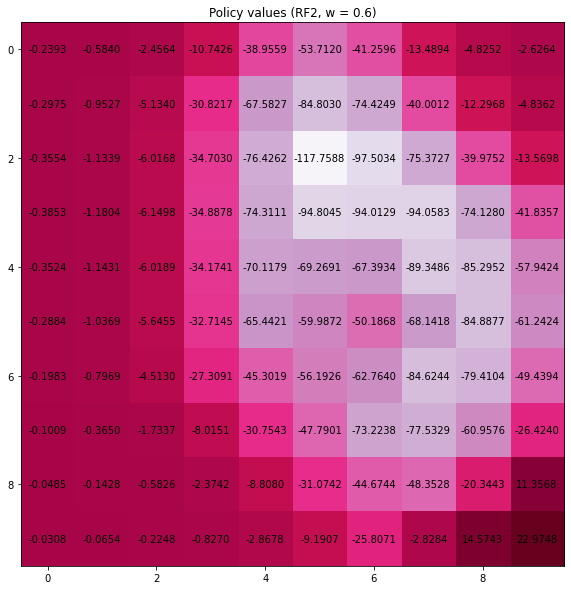

In [29]:
w = 0.6
gamma = 0.8
epsilon = 0.01
tp_u, tp_d, tp_l, tp_r = tp_calc(w)
V_opt, N=value_iteration(state_num,w,gamma,rwd_2,epsilon,tp_r,tp_l,tp_u,tp_d)
print("Number of steps needed to converge:", N)

fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(V_opt,cmap="PuRd")
for i in range(10):
    for j in range(10):
        c = "{:.4f}".format(V_opt[j,i])
        ax.text(i, j, str(c), va='center', ha='center')
plt.title("Optimal values of the states (RF2, w = 0.6)")
plt.savefig('Q9d.png',dpi=300,bbox_inches='tight')
plt.show()

plt.pcolor(V_opt,edgecolors='black')
plt.gca().invert_yaxis()
plt.colorbar()
plt.title("Heatmap for optimal state values (RF2, w = 0.6)")
plt.savefig('Q9e.png',dpi=300,bbox_inches='tight')
plt.show()

policy, pic_arrow,arrows = policy_iteration(state_num,w,gamma,rwd_2,epsilon,tp_u, tp_d, tp_l, tp_r)
print(pic_arrow)

fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(policy,cmap="PuRd")
for i in range(10):
    for j in range(10):
        c = "{:.4f}".format(policy[j,i])
        ax.text(i, j, str(c), va='center', ha='center')
plt.title("Policy values (RF2, w = 0.6)")
plt.savefig('Q9f.png',dpi=300,bbox_inches='tight')
plt.show()